In [ ]:
!pip install transformers datasets rouge_score
!pip install py7zr
!pip install gradio

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.4 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=2e5daba37efd0b71b00b827814040ff9e0690bfb9607642420f936554bc58ac8
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are 

100 dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.04k [00:00<?, ?B/s]

samsum.py:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

corpus.7z:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Epoch 1/3, Loss: 8.615624237060548
Epoch 2/3, Loss: 8.241943855285644
Epoch 3/3, Loss: 8.072749614715576


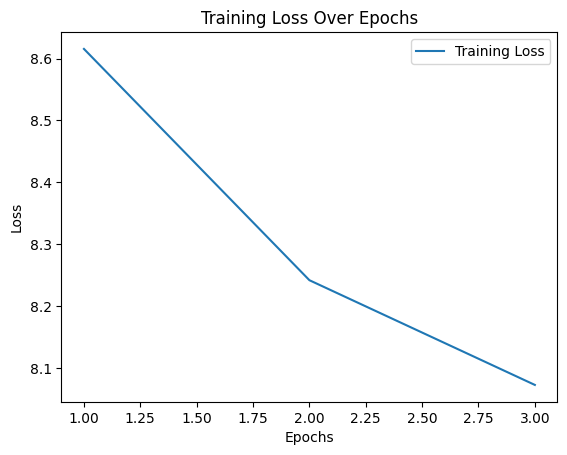

PEGASUS Test ROUGE Scores: {'rouge1': 0.28144198956154404, 'rouge2': 0.0833562061354494, 'rougeL': 0.21449851029585973}

Top 5 Most Accurate Summaries:

Example 1:
Dialogue: Flo: OMG, I can't get into the salon until the 6th! Gina: What? Why? Flo: They're just too busy. I'm going to be gray! LOL! Gina: Get you a touch-up kit at Tesco! Flo: Gonna have to!
Reference: Flo cannot get an appointment at the salon until the 6th. Flo worries she's going to be gray. Flo will have to get a touch-up kit at Tesco.
Generated Summary: Gina: Get you a touch-up kit at Tesco! Flo: Gonna have to!<n>Flo: OMG, I can't get into the salon until the 6th!
ROUGE-1 Score: 0.6071

Example 2:
Dialogue: Ernest: hey Mike, did you park your car on our street? Mike: no, took it into garage today Ernest: ok good Mike: why? Ernest: someone just crashed into a red honda looking just like yours Mike: lol lucky me
Reference: Mike took his car into garage today. Ernest is relieved as someone had just crashed into a red Hon

In [ ]:
import torch
from datasets import load_dataset
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from torch.utils.data import DataLoader
import torch.amp
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import numpy as np
import gradio as gr

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the SAMSum Dataset
dataset = load_dataset("samsum", trust_remote_code=True)
train_data = dataset["train"]
validation_data = dataset["validation"]
test_data = dataset["test"]

# Load Pre-trained PEGASUS Model and Tokenizer
model_name = "google/pegasus-cnn_dailymail"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

# Preprocessing Function
def preprocess_data(examples, tokenizer, max_input_len=256, max_target_len=64):
    inputs = tokenizer(examples['dialogue'], max_length=max_input_len, truncation=True, padding="max_length", return_tensors="pt")
    targets = tokenizer(examples['summary'], max_length=max_target_len, truncation=True, padding="max_length", return_tensors="pt")
    return {"input_ids": inputs.input_ids.squeeze(),
            "attention_mask": inputs.attention_mask.squeeze(),
            "labels": targets.input_ids.squeeze()}

# Preprocess the datasets
train_data = train_data.select(range(100)).map(lambda x: preprocess_data(x, tokenizer), batched=True)
validation_data = validation_data.select(range(100)).map(lambda x: preprocess_data(x, tokenizer), batched=True)
test_data = test_data.select(range(100)).map(lambda x: preprocess_data(x, tokenizer), batched=True)

# Convert Dataset to PyTorch DataLoader
def to_dataloader(dataset, batch_size=4):
    def collate_fn(batch):
        input_ids = torch.stack([torch.tensor(ex['input_ids']) for ex in batch])
        attention_mask = torch.stack([torch.tensor(ex['attention_mask']) for ex in batch])
        labels = torch.stack([torch.tensor(ex['labels']) for ex in batch])
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

    return DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

train_dataloader = to_dataloader(train_data)
validation_dataloader = to_dataloader(validation_data)
test_dataloader = to_dataloader(test_data)

# Define Optimizer and Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# Gradient Accumulation and Mixed Precision Training
accumulation_steps = 2
scaler = torch.amp.GradScaler('cuda')

# Gradient Clipping Value
max_grad_norm = 1.0

# Fine-tuning Loop with Gradient Accumulation and Mixed Precision
epochs = 3
train_losses = []

model.train()
for epoch in range(epochs):
    total_loss = 0
    optimizer.zero_grad()

    for i, batch in enumerate(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_dataloader):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    scheduler.step()  # Update learning rate
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

# Plot Training Loss
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

# ROUGE Evaluation Function
rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def evaluate_model(dataloader, model, tokenizer):
    rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
    all_summaries = []
    model.eval()
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Decode the original dialogues
        original_dialogues = tokenizer.batch_decode(input_ids, skip_special_tokens=True)

        with torch.no_grad():
            summary_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)

        generated_summaries = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)
        references = tokenizer.batch_decode(labels, skip_special_tokens=True)

        for dialogue, ref, gen in zip(original_dialogues, references, generated_summaries):
            scores = rouge_scorer_instance.score(ref, gen)
            rouge_scores["rouge1"].append(scores["rouge1"].fmeasure)
            rouge_scores["rouge2"].append(scores["rouge2"].fmeasure)
            rouge_scores["rougeL"].append(scores["rougeL"].fmeasure)
            all_summaries.append({
                "dialogue": dialogue,
                "reference": ref,
                "generated": gen,
                "rouge1": scores["rouge1"].fmeasure
            })

    avg_scores = {metric: np.mean(scores) for metric, scores in rouge_scores.items()}
    return avg_scores, all_summaries

def error_analysis(all_summaries, top_n=5):
    # Find the least accurate summaries
    least_accurate = sorted(all_summaries, key=lambda x: x['rouge1'])[:top_n]

    print("\nTop 5 Least Accurate Summaries:")
    for i, summary in enumerate(least_accurate):
        print(f"\nExample {i+1}:")
        print(f"Dialogue: {summary['dialogue']}")
        print(f"Reference: {summary['reference']}")
        print(f"Generated: {summary['generated']}")
        print(f"ROUGE-1 Score: {summary['rouge1']:.4f}")

# Evaluate on Test Set
test_scores, test_generated_summaries = evaluate_model(test_dataloader, model, tokenizer)
print("PEGASUS Test ROUGE Scores:", test_scores)

# Find and Print Top 5 Most Accurate Summaries
top_5_summaries = sorted(test_generated_summaries, key=lambda x: x['rouge1'], reverse=True)[:5]

print("\nTop 5 Most Accurate Summaries:")
for i, summary in enumerate(top_5_summaries):
    print(f"\nExample {i+1}:")
    print(f"Dialogue: {summary['dialogue']}")
    print(f"Reference: {summary['reference']}")
    print(f"Generated Summary: {summary['generated']}")
    print(f"ROUGE-1 Score: {summary['rouge1']:.4f}")

# Perform Error Analysis on Least Accurate Summaries
error_analysis(test_generated_summaries, top_n=5)

# Interactive Gradio Demo
def summarize_dialogue(dialogue):
    inputs = tokenizer(dialogue, max_length=256, truncation=True, return_tensors="pt").to(device)
    summary_ids = model.generate(inputs["input_ids"], max_length=128, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

gr.Interface(fn=summarize_dialogue,
             inputs="text",
             outputs="text",
             title="Dialogue Summarizer with PEGASUS").launch()


10000 dataset

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Epoch 1/3, Loss: 5.262517553305626
Epoch 2/3, Loss: 0.7690966982126236
Epoch 3/3, Loss: 0.6781591611802578


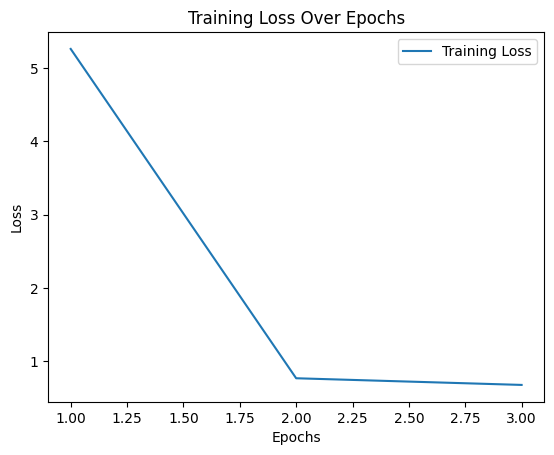

PEGASUS Test ROUGE Scores: {'rouge1': 0.44917622550043074, 'rouge2': 0.21443821722170023, 'rougeL': 0.3556610350990039}

Top 5 Most Accurate Summaries:

Example 1:
Dialogue: Paul: I just came back home Paul: What a busy day Paul: I forgot about my physiotherapy Emma: Oh no Paul: It's ok, I'll schedule a new appointment Emma: I'll be home after midnight Paul: Do you want me to prepare some food for you? Emma: That would be lovely
Reference: Paul forgot about his physiotherapy and he will schedule a new appointment. Emma will be home after midnight, so Paul will prepare some food for her.
Generated Summary: Paul forgot about his physiotherapy appointment. He will schedule a new appointment. Emma will be home after midnight. Paul will prepare some food for her and she will be there.
ROUGE-1 Score: 0.8929

Example 2:
Dialogue: Paul: Do you have your keys? Lena: Yup. What's up? Paul: I will be home later than I thought, so just don't wait for me and get home. Lena: What happened? Paul: I'll

In [ ]:
import torch
from datasets import load_dataset
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from torch.utils.data import DataLoader
import torch.amp
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import numpy as np
import gradio as gr

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the SAMSum Dataset
dataset = load_dataset("samsum", trust_remote_code=True)
train_data = dataset["train"]
validation_data = dataset["validation"]
test_data = dataset["test"]

# Load Pre-trained PEGASUS Model and Tokenizer
model_name = "google/pegasus-cnn_dailymail"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

# Preprocessing Function
def preprocess_data(examples, tokenizer, max_input_len=256, max_target_len=64):
    inputs = tokenizer(examples['dialogue'], max_length=max_input_len, truncation=True, padding="max_length", return_tensors="pt")
    targets = tokenizer(examples['summary'], max_length=max_target_len, truncation=True, padding="max_length", return_tensors="pt")
    return {"input_ids": inputs.input_ids.squeeze(),
            "attention_mask": inputs.attention_mask.squeeze(),
            "labels": targets.input_ids.squeeze()}

# Preprocess the datasets
train_data = train_data.select(range(10000)).map(lambda x: preprocess_data(x, tokenizer), batched=True)
validation_data = validation_data.map(lambda x: preprocess_data(x, tokenizer), batched=True)
test_data = test_data.map(lambda x: preprocess_data(x, tokenizer), batched=True)

# Convert Dataset to PyTorch DataLoader
def to_dataloader(dataset, batch_size=4):
    def collate_fn(batch):
        input_ids = torch.stack([torch.tensor(ex['input_ids']) for ex in batch])
        attention_mask = torch.stack([torch.tensor(ex['attention_mask']) for ex in batch])
        labels = torch.stack([torch.tensor(ex['labels']) for ex in batch])
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

    return DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

train_dataloader = to_dataloader(train_data)
validation_dataloader = to_dataloader(validation_data)
test_dataloader = to_dataloader(test_data)

# Define Optimizer and Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# Gradient Accumulation and Mixed Precision Training
accumulation_steps = 2
scaler = torch.amp.GradScaler('cuda')

# Gradient Clipping Value
max_grad_norm = 1.0

# Fine-tuning Loop with Gradient Accumulation and Mixed Precision
epochs = 3
train_losses = []

model.train()
for epoch in range(epochs):
    total_loss = 0
    optimizer.zero_grad()

    for i, batch in enumerate(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_dataloader):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    scheduler.step()  # Update learning rate
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

# Plot Training Loss
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

# ROUGE Evaluation Function
rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def evaluate_model(dataloader, model, tokenizer):
    rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
    all_summaries = []
    model.eval()
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Decode the original dialogues
        original_dialogues = tokenizer.batch_decode(input_ids, skip_special_tokens=True)

        with torch.no_grad():
            summary_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)

        generated_summaries = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)
        references = tokenizer.batch_decode(labels, skip_special_tokens=True)

        for dialogue, ref, gen in zip(original_dialogues, references, generated_summaries):
            scores = rouge_scorer_instance.score(ref, gen)
            rouge_scores["rouge1"].append(scores["rouge1"].fmeasure)
            rouge_scores["rouge2"].append(scores["rouge2"].fmeasure)
            rouge_scores["rougeL"].append(scores["rougeL"].fmeasure)
            all_summaries.append({
                "dialogue": dialogue,
                "reference": ref,
                "generated": gen,
                "rouge1": scores["rouge1"].fmeasure
            })

    avg_scores = {metric: np.mean(scores) for metric, scores in rouge_scores.items()}
    return avg_scores, all_summaries

def error_analysis(all_summaries, top_n=5):
    # Find the least accurate summaries
    least_accurate = sorted(all_summaries, key=lambda x: x['rouge1'])[:top_n]

    print("\nTop 5 Least Accurate Summaries:")
    for i, summary in enumerate(least_accurate):
        print(f"\nExample {i+1}:")
        print(f"Dialogue: {summary['dialogue']}")
        print(f"Reference: {summary['reference']}")
        print(f"Generated: {summary['generated']}")
        print(f"ROUGE-1 Score: {summary['rouge1']:.4f}")

# Evaluate on Test Set
test_scores, test_generated_summaries = evaluate_model(test_dataloader, model, tokenizer)
print("PEGASUS Test ROUGE Scores:", test_scores)

# Find and Print Top 5 Most Accurate Summaries
top_5_summaries = sorted(test_generated_summaries, key=lambda x: x['rouge1'], reverse=True)[:5]

print("\nTop 5 Most Accurate Summaries:")
for i, summary in enumerate(top_5_summaries):
    print(f"\nExample {i+1}:")
    print(f"Dialogue: {summary['dialogue']}")
    print(f"Reference: {summary['reference']}")
    print(f"Generated Summary: {summary['generated']}")
    print(f"ROUGE-1 Score: {summary['rouge1']:.4f}")

# Perform Error Analysis on Least Accurate Summaries
error_analysis(test_generated_summaries, top_n=5)

# Interactive Gradio Demo
def summarize_dialogue(dialogue):
    inputs = tokenizer(dialogue, max_length=256, truncation=True, return_tensors="pt").to(device)
    summary_ids = model.generate(inputs["input_ids"], max_length=128, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [ ]:

gr.Interface(fn=summarize_dialogue,
             inputs="text",
             outputs="text",
             title="Dialogue Summarizer with PEGASUS").launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://784634d82b55bca925.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


full dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.04k [00:00<?, ?B/s]

samsum.py:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

corpus.7z:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Epoch 1/3, Loss: 3.7957752207974327
Epoch 2/3, Loss: 0.6922058086258673
Epoch 3/3, Loss: 0.6515276399022563


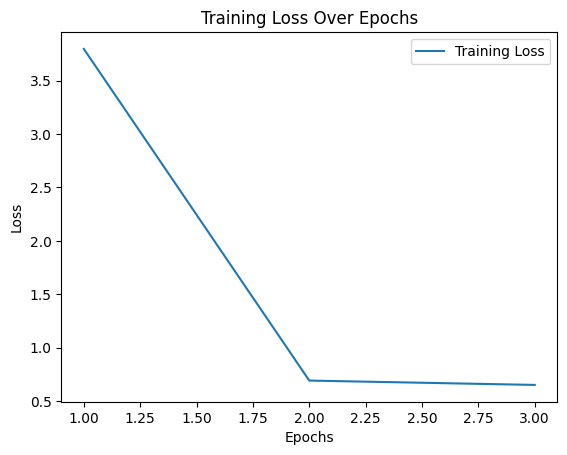

PEGASUS Test ROUGE Scores: {'rouge1': 0.45363614342291564, 'rouge2': 0.21981657694561776, 'rougeL': 0.35953420091458516}

Top 5 Most Accurate Summaries:

Example 1:
Dialogue: John: hey laurel? Laurel: hey John: whats your plan for tomorrow? Laurel: aint that sure yet, why? John: nothing much, just wanted to go with you and buy a birthday gift for Diana. Laurel: OMG! i also totally forgot that her birthday is on saturday, shit! John: you see im not the only late one here. haha Laurel: I guess we can meet up tomorrow and go fetch something for her. John: cool, at what time? Laurel: lets just meet at jades at around 5 pm John: At Jade's collection? in town? Laurel: yeah, that place.. John: see you then.
Reference: Laurel and John meet at Jades tomorrow at 5 pm to buy a birthday gift for Diana. Diana's birthday is on Saturday.
Generated Summary: John and Laurel will meet at Jade's collection at around 5 pm tomorrow to buy a birthday gift for Diana. Diana's birthday is on Saturday.
ROUGE-1 

In [ ]:
import torch
from datasets import load_dataset
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from torch.utils.data import DataLoader
import torch.amp
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import numpy as np
import gradio as gr

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the SAMSum Dataset
dataset = load_dataset("samsum", trust_remote_code=True)
train_data = dataset["train"]
validation_data = dataset["validation"]
test_data = dataset["test"]

# Load Pre-trained PEGASUS Model and Tokenizer
model_name = "google/pegasus-cnn_dailymail"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)

# Preprocessing Function
def preprocess_data(examples, tokenizer, max_input_len=256, max_target_len=64):
    inputs = tokenizer(examples['dialogue'], max_length=max_input_len, truncation=True, padding="max_length", return_tensors="pt")
    targets = tokenizer(examples['summary'], max_length=max_target_len, truncation=True, padding="max_length", return_tensors="pt")
    return {"input_ids": inputs.input_ids.squeeze(),
            "attention_mask": inputs.attention_mask.squeeze(),
            "labels": targets.input_ids.squeeze()}

# Preprocess the datasets
# train_data = train_data.select(range(100)).map(lambda x: preprocess_data(x, tokenizer), batched=True)
train_data = train_data.map(lambda x: preprocess_data(x, tokenizer), batched=True)
validation_data = validation_data.map(lambda x: preprocess_data(x, tokenizer), batched=True)
test_data = test_data.map(lambda x: preprocess_data(x, tokenizer), batched=True)

# Convert Dataset to PyTorch DataLoader
def to_dataloader(dataset, batch_size=4):
    def collate_fn(batch):
        input_ids = torch.stack([torch.tensor(ex['input_ids']) for ex in batch])
        attention_mask = torch.stack([torch.tensor(ex['attention_mask']) for ex in batch])
        labels = torch.stack([torch.tensor(ex['labels']) for ex in batch])
        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

    return DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

train_dataloader = to_dataloader(train_data)
validation_dataloader = to_dataloader(validation_data)
test_dataloader = to_dataloader(test_data)

# Define Optimizer and Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# Gradient Accumulation and Mixed Precision Training
accumulation_steps = 2
scaler = torch.amp.GradScaler('cuda')

# Gradient Clipping Value
max_grad_norm = 1.0

# Fine-tuning Loop with Gradient Accumulation and Mixed Precision
epochs = 3
train_losses = []

model.train()
for epoch in range(epochs):
    total_loss = 0
    optimizer.zero_grad()

    for i, batch in enumerate(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_dataloader):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    scheduler.step()  # Update learning rate
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

# Plot Training Loss
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

# ROUGE Evaluation Function
rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def evaluate_model(dataloader, model, tokenizer):
    rouge_scores = {"rouge1": [], "rouge2": [], "rougeL": []}
    all_summaries = []
    model.eval()
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Decode the original dialogues
        original_dialogues = tokenizer.batch_decode(input_ids, skip_special_tokens=True)

        with torch.no_grad():
            summary_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)

        generated_summaries = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)
        references = tokenizer.batch_decode(labels, skip_special_tokens=True)

        for dialogue, ref, gen in zip(original_dialogues, references, generated_summaries):
            scores = rouge_scorer_instance.score(ref, gen)
            rouge_scores["rouge1"].append(scores["rouge1"].fmeasure)
            rouge_scores["rouge2"].append(scores["rouge2"].fmeasure)
            rouge_scores["rougeL"].append(scores["rougeL"].fmeasure)
            all_summaries.append({
                "dialogue": dialogue,
                "reference": ref,
                "generated": gen,
                "rouge1": scores["rouge1"].fmeasure
            })

    avg_scores = {metric: np.mean(scores) for metric, scores in rouge_scores.items()}
    return avg_scores, all_summaries

def error_analysis(all_summaries, top_n=5):
    # Find the least accurate summaries
    least_accurate = sorted(all_summaries, key=lambda x: x['rouge1'])[:top_n]

    print("\nTop 5 Least Accurate Summaries:")
    for i, summary in enumerate(least_accurate):
        print(f"\nExample {i+1}:")
        print(f"Dialogue: {summary['dialogue']}")
        print(f"Reference: {summary['reference']}")
        print(f"Generated: {summary['generated']}")
        print(f"ROUGE-1 Score: {summary['rouge1']:.4f}")

# Evaluate on Test Set
test_scores, test_generated_summaries = evaluate_model(test_dataloader, model, tokenizer)
print("PEGASUS Test ROUGE Scores:", test_scores)

# Find and Print Top 5 Most Accurate Summaries
top_5_summaries = sorted(test_generated_summaries, key=lambda x: x['rouge1'], reverse=True)[:5]

print("\nTop 5 Most Accurate Summaries:")
for i, summary in enumerate(top_5_summaries):
    print(f"\nExample {i+1}:")
    print(f"Dialogue: {summary['dialogue']}")
    print(f"Reference: {summary['reference']}")
    print(f"Generated Summary: {summary['generated']}")
    print(f"ROUGE-1 Score: {summary['rouge1']:.4f}")

# Perform Error Analysis on Least Accurate Summaries
error_analysis(test_generated_summaries, top_n=5)

# Interactive Gradio Demo
def summarize_dialogue(dialogue):
    inputs = tokenizer(dialogue, max_length=256, truncation=True, return_tensors="pt").to(device)
    summary_ids = model.generate(inputs["input_ids"], max_length=128, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

gr.Interface(fn=summarize_dialogue,
             inputs="text",
             outputs="text",
             title="Dialogue Summarizer with PEGASUS").launch()
